In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
from matplotlib.pyplot import figure

In [2]:
torch.manual_seed(1)

In [3]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [4]:
# Data loader func
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [5]:
class DNN(nn.Module):
    def __init__(self,):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# m = DNN()
# p1=torch.nn.utils.parameters_to_vector(m.fc1.weight.data).detach().numpy()

# print(p1)

In [7]:
# testDict = {}

# for name, parameter in m.named_parameters():
#     if'weight' in name:
#         testDict['b'] = (torch.nn.utils.parameters_to_vector(parameter).detach().numpy())
#         #testDict['b'].append(weights2)
# len(testDict)

In [8]:
# temp_df = pd.DataFrame()
# for name, parameter in m.named_parameters():
#             if 'weight' in name:
#                 weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
#                 temp_df = pd.concat([temp_df, pd.DataFrame(weights).T], axis = 1)
                
# temp_df

In [9]:
# temp_df = pd.DataFrame()
# for name, parameter in m.named_parameters():
#             if 'weight' in name and 'fc3'in name:
#                 weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
#                 temp_df = pd.concat([temp_df, pd.DataFrame(weights).T], axis = 1)
                
# temp_df

In [10]:
# print(p1 == p2)

In [11]:
#train function
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt = pd.DataFrame()
    trainAvgLossArr = []
    trainAvgAccArr = []
    firstParaWgt = {}

    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc=0
        epoch_df = pd.DataFrame()

        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()

            # Backward and optimize
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            #Print Status
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
        
        #Weight Collection
        for name, parameter in model.named_parameters():
            #print(name)
            if'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
                epoch_df = pd.concat([epoch_df, pd.DataFrame(weights).T], axis = 1) 

        modelParamWgt = pd.concat([modelParamWgt, epoch_df], axis = 0)     

       
        epochLoss = lossSum/n_total_steps
        epochAcc = totalacc/n_total_steps
        #print("Train Avg loss:",trainAvgLoss)
        trainAvgLossArr.append(epochLoss)    
        trainAvgAccArr.append(epochAcc)
                       
    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr, modelParamWgt

In [12]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [13]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    pcaVal = pcaOperation.fit_transform(paramDF)

    itrData = np.full((pcaVal.shape[0],1),itr)

    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf


In [14]:
a=[]
tempModel = DNN()
for i in tempModel.parameters():
    a.append(torch.numel(i))
print(f'Total no of parameters:{np.sum(a)}')

Total no of parameters:418060


In [15]:
#2nd Approach

max_epochs = 45
all_df = pd.DataFrame()
columns=["x","y","Times"]
trainAllacc={}
testAllacc={}
trainAllloss={}
testAllloss={}
train_batch_size = 1000
test_batch_size = 1000
status_interval = 60
loss_func = nn.CrossEntropyLoss()
firstLayer = pd.DataFrame()

for count in range(8):

    j = copy.deepcopy(count)

    j = DNN()  

    print("Time: "+str(count))
    optimizer = torch.optim.Adam(j.parameters(),lr = 0.0004,weight_decay=1e-4)
    model_name1 = "Times:"+str(count)  
    
    train_epoch,train_losses,train_acc,trainAvgLoss,trainAvgAccArr, modelParamWgt,firstParamWgt = trainFunc(j,max_epochs,train_batch_size,status_interval)
    testAcc, testLoss = testFunction(j,loss_func,test_batch_size)

    all_df = all_df.append(modelParamWgt)
    
    testAllacc[count] = testAcc
    trainAllloss[count] = trainAvgLoss
    testAllloss[count] = testLoss
    trainAllacc[count] = trainAvgAccArr


Time: 0
strated
Time: 1y of the network on the test images: 98.17% & Test Loss: 0.06214663684368134
strated
Time: 2y of the network on the test images: 98.17% & Test Loss: 0.06214663684368134
strated
Time: 3y of the network on the test images: 98.17% & Test Loss: 0.06214663684368134
strated
Time: 4y of the network on the test images: 98.17% & Test Loss: 0.06214663684368134
strated
Time: 5y of the network on the test images: 98.17% & Test Loss: 0.06214663684368134
strated
Time: 6y of the network on the test images: 98.17% & Test Loss: 0.06214663684368134
strated
Time: 7y of the network on the test images: 98.17% & Test Loss: 0.06214663684368134
strated


In [16]:
trainAccArr = []
for key,values in enumerate(trainAllacc):
    trainAccArr.append(trainAllacc[key])
trainLossArr = []
for key,values in enumerate(trainAllloss):
    trainLossArr.append(trainAllloss[key])


In [17]:
all_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.108452e-03,3.076525e-05,-2.651312e-04,3.421936e-04,-1.268616e-02,2.904374e-03,-2.349899e-04,9.891548e-04,-2.102836e-05,1.311653e-04,...,-0.119286,-0.009101,-0.065067,0.118004,-0.106717,-0.164172,-0.053234,-0.081339,-0.080208,-0.036831
0,-4.739522e-05,-3.164027e-05,9.815199e-08,8.226781e-06,-2.607091e-03,-9.914978e-05,-8.893148e-06,-3.921824e-05,7.500358e-06,-2.689069e-06,...,-0.130349,-0.006834,-0.080467,0.130852,-0.129759,-0.172083,-0.062098,-0.095710,-0.090356,-0.043638
0,-1.269553e-07,1.569342e-06,-2.580924e-08,-2.326338e-06,-2.287546e-04,4.477086e-06,5.372725e-07,-6.516146e-07,1.268538e-07,-3.920284e-08,...,-0.137011,-0.005980,-0.091931,0.138971,-0.157257,-0.176509,-0.069453,-0.107274,-0.095383,-0.046607
0,1.300539e-07,8.491727e-08,2.124261e-08,-5.194166e-09,-1.711311e-06,-2.246634e-07,-1.347103e-08,1.272403e-07,1.081522e-08,1.379866e-08,...,-0.141709,-0.005171,-0.101017,0.145978,-0.178843,-0.180453,-0.075584,-0.119624,-0.098053,-0.047095
0,2.778485e-10,2.599349e-09,-4.413521e-10,3.205889e-09,3.577440e-07,4.251778e-09,-8.010753e-10,1.935141e-09,6.821802e-10,-2.647242e-10,...,-0.145790,-0.004706,-0.109504,0.151184,-0.195017,-0.183493,-0.079563,-0.131426,-0.099415,-0.046909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,9.008348e-39,-9.403872e-39,-1.102205e-38,-6.176625e-39,-1.082504e-38,4.926252e-39,4.125347e-39,-2.497178e-39,1.532827e-38,3.156683e-38,...,-0.229161,-0.012143,-0.274434,0.268113,-0.418617,-0.248419,-0.151194,-0.377344,-0.180246,-0.055528
0,9.008348e-39,-9.403872e-39,-1.102205e-38,-6.176625e-39,-1.082504e-38,4.926252e-39,4.125347e-39,-2.497178e-39,1.532827e-38,-4.085126e-38,...,-0.231176,-0.012140,-0.276585,0.270454,-0.422120,-0.249731,-0.152306,-0.381729,-0.181646,-0.055522
0,9.008348e-39,-9.403872e-39,-1.102205e-38,-6.176625e-39,-1.082504e-38,4.926252e-39,4.125347e-39,-2.497178e-39,1.532827e-38,-4.153385e-38,...,-0.232919,-0.012213,-0.279647,0.272979,-0.425895,-0.251312,-0.153784,-0.385938,-0.183550,-0.055799
0,9.008348e-39,-9.403872e-39,-1.102205e-38,-6.176625e-39,-1.082504e-38,4.926252e-39,4.125347e-39,-2.497178e-39,1.532827e-38,3.293197e-38,...,-0.235038,-0.012295,-0.282234,0.275224,-0.429751,-0.252842,-0.154945,-0.390308,-0.185046,-0.056044


In [18]:
train_acc_df = pd.DataFrame(trainAccArr)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')


Shape of Loss:(360,) & Shape of Acc: (360,)


In [19]:
t1 = all_df
print(pd.DataFrame(t1))

             0             1             2             3             4    \
0   1.108452e-03  3.076525e-05 -2.651312e-04  3.421936e-04 -1.268616e-02   
0  -4.739522e-05 -3.164027e-05  9.815199e-08  8.226781e-06 -2.607091e-03   
0  -1.269553e-07  1.569342e-06 -2.580924e-08 -2.326338e-06 -2.287546e-04   
0   1.300539e-07  8.491727e-08  2.124261e-08 -5.194166e-09 -1.711311e-06   
0   2.778485e-10  2.599349e-09 -4.413521e-10  3.205889e-09  3.577440e-07   
..           ...           ...           ...           ...           ...   
0   9.008348e-39 -9.403872e-39 -1.102205e-38 -6.176625e-39 -1.082504e-38   
0   9.008348e-39 -9.403872e-39 -1.102205e-38 -6.176625e-39 -1.082504e-38   
0   9.008348e-39 -9.403872e-39 -1.102205e-38 -6.176625e-39 -1.082504e-38   
0   9.008348e-39 -9.403872e-39 -1.102205e-38 -6.176625e-39 -1.082504e-38   
0   9.008348e-39 -9.403872e-39 -1.102205e-38 -6.176625e-39 -1.082504e-38   

             5             6             7             8             9    ...  \
0   2.

In [20]:
t1 = np.array(t1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1)
# scaling=StandardScaler()
# scaled_data = scaling.fit_transform(new_data)

allEpochDf = pd.DataFrame(new_data,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

allEpochDf['Epoch']=eps_each_time
allEpochDf['Iteration']=(times)
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data

allEpochDf


,x,y,Epoch,Iteration,Acc,Loss
0,11.484435,7.364438,0,0,47.131791,1.286802
1,11.699397,5.562063,1,0,88.437144,0.394324
2,11.393364,4.006983,2,0,91.463650,0.294259
3,10.835290,2.569232,3,0,92.772298,0.251976
4,10.134159,1.304998,4,0,93.789547,0.220068
...,...,...,...,...,...,...
355,-6.218816,2.322319,40,7,99.621042,0.019140
356,-6.321358,2.493414,41,7,99.767292,0.017648
357,-6.406707,2.646224,42,7,99.753405,0.016912
358,-6.495262,2.797075,43,7,99.824129,0.016311


In [21]:
epoch3Df = allEpochDf.loc[(allEpochDf['Epoch']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
epoch3Df

,x,y,Epoch,Iteration,Acc,Loss
0,11.393364,4.006983,2,0,91.463650,0.294259
1,9.356701,0.230622,5,0,94.410890,0.194354
2,6.851554,-1.993984,8,0,95.896526,0.140965
3,4.415884,-2.990983,11,0,96.933228,0.107872
4,2.273011,-3.161357,14,0,97.682687,0.085037
...,...,...,...,...,...,...
115,-4.990288,0.738444,32,7,99.387775,0.027764
116,-5.546024,1.369022,35,7,99.541669,0.024140
117,-5.987475,1.956722,38,7,99.680361,0.020665
118,-6.321358,2.493414,41,7,99.767292,0.017648


In [22]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))
len(mv)

120

In [23]:
cmap = ['red','blue','purple','green','yellow','brown','black','grey']

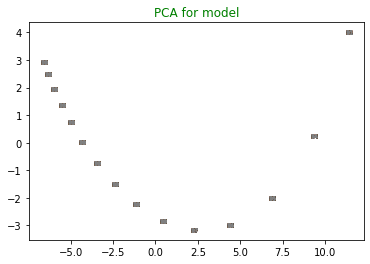

<Figure size 5000x2500 with 0 Axes>

In [24]:

for i in range(len(mv)):
    m = mv[i]
    c = epoch3Df['Iteration'][i]
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for model",color="g")
    
plt.figure(figsize=[10,5],dpi=500)

plt.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/plots/PCA_1Copy.jpg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()

In [25]:
layer1_Df = all_df.iloc[:,0:7840]


In [26]:
t2 = layer1_Df 
t2 = np.array(t2)
pca = PCA(n_components=2)
new_data2 = pca.fit_transform(t2)

In [27]:
layer1Df = pd.DataFrame(new_data2,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

layer1Df['Epoch']=eps_each_time
layer1Df['Iteration']=(times)
layer1Df["Acc"] = train_acc_data
layer1Df["Loss"] = train_loss_data

layer1Df

,x,y,Epoch,Iteration,Acc,Loss
0,1.214312,1.007225,0,0,47.131791,1.286802
1,1.332997,0.756948,1,0,88.437144,0.394324
2,1.340704,0.539317,2,0,91.463650,0.294259
3,1.305381,0.346261,3,0,92.772298,0.251976
4,1.248238,0.183395,4,0,93.789547,0.220068
...,...,...,...,...,...,...
355,-0.784708,0.275449,40,7,99.621042,0.019140
356,-0.796055,0.302956,41,7,99.767292,0.017648
357,-0.807146,0.319752,42,7,99.753405,0.016912
358,-0.818237,0.335618,43,7,99.824129,0.016311


In [28]:
test = np.array(layer1Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))


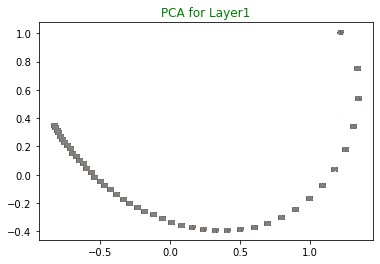

In [29]:
for i in range(len(mv)):
    m = mv[i]
    c = layer1Df['Iteration'][i]
    plt.scatter(layer1Df['x'][i],layer1Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for Layer1",color="g")

plt.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/plots/PCA_Layer1.jpg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()